In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load stored data sets, vocabulary and tokenizer

All required libraries

In [ ]:
import pickle

Let's load our previously pickled datasets

In [ ]:
STORED =  "/content/drive/MyDrive/recipes_processed/"

with open(STORED + 'recipe_train_new.pkl', 'rb') as f:
    train_data = pickle.load(f)

with open(STORED + 'recipe_validation_new.pkl', 'rb') as g:
    validation_data = pickle.load(g)

with open(STORED + 'recipe_test_new.pkl', 'rb') as h:
    test_data = pickle.load(h)

with open(STORED + 'recipe_vocab_new.pkl', 'rb') as i:
    vocabulary = pickle.load(i)

with open(STORED + 'recipe_tokenizer_new.pkl', 'rb') as j:
    tokenizer = pickle.load(j)

print("Size of Training Set: ", len(train_data))
print("Size of Validation Set: ", len(validation_data))
print("Size of Test Set: ", len(test_data))

Size of Training Set:  48538
Size of Validation Set:  16179
Size of Test Set:  16181


# Functions for Model Training and Evaluation


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import numpy as np
from nltk.translate.bleu_score import sentence_bleu
import random

Let's write a function to batch the training data so we can do batch training.

In [ ]:
# Generates tensors X, T of size [batch_size, input_length] and [batch_size, target_length]
def generate_batch(batch):
    x_list = []
    t_list = []
    for x, t in batch:
        x_list.append(x)
        t_list.append(t)
    X = torch.tensor(x_list)
    T = torch.tensor(t_list)
    return X, T

Let's write a function to evaluate the model on validation set

In [ ]:
def evaluate_model(model, data_loader, criterion):
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for input, target in data_loader:
            z = model(input.to(model.device), target.to(model.device), 0).to(model.device)
            loss = criterion(z.view(-1, z.shape[2]), target.view(-1).to(model.device))
            total_loss += loss.item()

    model.train()

    perplexity = 2**(total_loss / len(data_loader))
    return perplexity

Let's write a function that will sample 'n' data points from the test set. It will then run the run on that point and will return the prediction and the number of words commong between the input and the prediction.

Note: It will sample a max of len(test_set)/batch_size points from the tests set.

In [ ]:
def generate_text(model, data, num_samples=2):
    model.eval()
    with torch.no_grad():
        data_loader = torch.utils.data.DataLoader(data, batch_size=100, collate_fn=generate_batch)
        predictions, truths, inputs = [], [], []
        index_to_str = vocabulary.get_itos()

        random_indices = random.sample(range(len(data_loader)), min(num_samples, len(data_loader)))
        for i, (input, target) in enumerate(data_loader):
            if i in random_indices:
                input, target = input.to(model.device), target.to(model.device)
                z = model(input, target, 0)

                for pred_row, truth_row, inp_row in zip(z.argmax(dim=2).tolist(), target.tolist(), input.tolist()):
                    batch_predictions = ' '.join(index_to_str[ind] for ind in pred_row)
                    batch_truths = ' '.join(index_to_str[ind] for ind in truth_row)
                    batch_inputs = ' '.join(index_to_str[ind] for ind in inp_row)

                    predictions.append(batch_predictions)
                    truths.append(batch_truths)
                    inputs.append(batch_inputs)
                    break

        commons = []
        for i in range(len(predictions)):
            input_words = set(inputs[i].split())
            prediction_words = set(predictions[i].split())
            commons.append(input_words.intersection(prediction_words))

        model.train()
        return predictions, truths, inputs, commons


Let's write a function to train a model

In [ ]:
def train_model(model, train_data, validation_data, test_data, criterion, optimizer_encoder, optimizer_decoder, learning_rate,
                batch_size, teacher_forcing, num_epochs, plot_every, stats, plot=True):
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, collate_fn=generate_batch, shuffle=True)
    validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, collate_fn=generate_batch)

    print("Learning Rate: ", learning_rate, "Batch Size: ", batch_size, "Epochs: ", num_epochs)
    iters, train_loss, train_perplexity, val_perplexity = stats['iters'], stats['train_loss'], stats['train_perp'], stats['val_perp']
    iter_count = 0

    try:
        for e in range(num_epochs):
            for i, (input, target) in enumerate(train_loader):
                z = model(input.to(model.device), target.to(model.device),teacher_forcing).to(model.device)
                loss = criterion(z.view(-1, z.shape[2]), target.view(-1).to(model.device))
                loss.backward()

                optimizer_encoder.step()
                optimizer_encoder.zero_grad()
                optimizer_decoder.step()
                optimizer_decoder.zero_grad()

                iter_count += 1
                if iter_count % plot_every == 0:
                    iters.append(iter_count)
                    train_loss.append(float(loss))
                    print(iter_count, "Training Loss:", float(loss))

                    # training perplexity
                    train_perplex_val = 2 ** float(loss)
                    train_perplexity.append(train_perplex_val)

                    # Validation perplexity
                    val_perplex_val = evaluate_model(model, validation_loader, criterion)
                    val_perplexity.append(val_perplex_val)

                    print(iter_count, "Training perplexity:", float(train_perplex_val), "Validation perplexity:", val_perplex_val)

                    # Generate a random recipe for human evaluation
                    predictions, truths, gen_inputs, common_words = generate_text(model, test_data)
                    for i in range(len(predictions)):
                        print(f"Sample {i + 1}:")
                        print("Ingredients:", gen_inputs[i])
                        print("Prediction:", predictions[i])
                        print("Target:", truths[i])
                        print("Common Words:", common_words[i])
                        print("\n")

    finally:
        if plot:
            fig, axs = plt.subplots(1, 2, figsize=(12, 5))

            # Plotting training loss
            axs[0].plot(iters, train_loss, label="Training Loss", color='red')
            axs[0].set_title("Training Loss over Iterations")
            axs[0].set_xlabel("Iterations")
            axs[0].set_ylabel("Loss")
            axs[0].legend()

            # Plotting training perplexity
            axs[1].plot(iters, train_perplexity, label="Training Perplexity", color='blue')
            axs[1].plot(iters, val_perplexity, label="Validation Perplexity", color='green')
            axs[1].set_title("Training and Validation Perplexity over Iterations")
            axs[1].set_xlabel("Iterations")
            axs[1].set_ylabel("Perplexity")
            axs[1].legend()

            plt.show()

# Baseline Decoder Model

Let's declare a basic Encoder Decoder Model


In [ ]:
class BaseEncoder(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_prob=0.1):
      # input_size = vocab_size, hidden_size = hyperparameter
        super(BaseEncoder, self).__init__()
        self.dropout = nn.Dropout(dropout_prob)
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size,batch_first=True)

    def forward(self, input_seq, hidden_state):
        embedded = self.dropout(self.embedding(input_seq))
        output, hidden_state = self.lstm(embedded, hidden_state)
        return output, hidden_state

    def init_hidden(self, batch_size):
        return (torch.zeros(1, batch_size, self.lstm.hidden_size), torch.zeros(1, batch_size, self.lstm.hidden_size))


class BaseDecoder(nn.Module):
    def __init__(self, hidden_size, vocab_size,dropout_prob):
      # output_size = vocab_size, hidden_size = hyperparameter
        super(BaseDecoder, self).__init__()
        self.dropout = nn.Dropout(dropout_prob)
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size,batch_first=True)
        self.out = nn.Linear(hidden_size, vocab_size)
        self.softmax = nn.LogSoftmax(dim=2)

    def forward(self, target_seq, hidden_state):
        embedded = self.dropout(self.embedding(target_seq))
        output, hidden_state = self.lstm(embedded, hidden_state)
        output = self.softmax(self.out(output))
        return output, hidden_state

class BaseEncoderDecoder(nn.Module):
    def __init__(self, vocabulary_size, hidden_size,device, dropout_prob = 0.1):
        super(BaseEncoderDecoder, self).__init__()
        self.encoder = BaseEncoder(vocabulary_size, hidden_size, dropout_prob)
        self.decoder = BaseDecoder(hidden_size, vocabulary_size, dropout_prob)
        self.vocabulary_size = vocabulary_size
        self.device = device

    def forward(self, input, target, teacher_forcing):
        # input shape = [batch_size, input_seq_length]
        # target shape = [batch_size, target_seq_length]
        batch_size = input.shape[0]
        target_length = target.shape[1]

        # Encoder Processing
        encoder_hidden = (self.encoder.init_hidden(batch_size)[0].to(self.device), self.encoder.init_hidden(batch_size)[1].to(self.device))
        encoder_output, encoder_hidden = self.encoder(input, encoder_hidden)
        encoder_output = encoder_output.to(self.device)

        # Encoder output transitioned into encoder input
        decoder_hidden = encoder_hidden
        final_outputs = torch.zeros(batch_size, target_length,self.vocabulary_size).to(self.device)
        decoder_input = target[:,0].to(self.device)

        for t in range(target_length):
            enable_teacher_forcing = random.random() < teacher_forcing
            decoder_output, decoder_hidden = self.decoder(decoder_input.unsqueeze(1), decoder_hidden)
            if enable_teacher_forcing and  t < (target_length - 1):
                decoder_input = target[:, t+1].to(self.device)
            else:
                decoder_input = decoder_output.argmax(dim=2).squeeze(1).to(self.device)
            final_outputs[:, t,: ] = decoder_output.squeeze(1)

        return final_outputs

# Attention Encoder and Decoder Model

Let's declare the Attention Encoder-Decoder Model

In [ ]:
class AttentionEncoder(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_prob=0.1):
      # input_size = vocab_size, hidden_size = hyperparameter
        super(AttentionEncoder, self).__init__()
        self.dropout = nn.Dropout(dropout_prob)
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size,batch_first=True)

    def forward(self, input_seq, hidden_state):
        embedded = self.dropout(self.embedding(input_seq))
        output, hidden_state = self.lstm(embedded, hidden_state)
        return output, hidden_state

    def init_hidden(self, batch_size):
        return (torch.zeros(1, batch_size, self.lstm.hidden_size), torch.zeros(1, batch_size, self.lstm.hidden_size))

class LuongAttention(nn.Module):
    def forward(self, decoder_hidden, encoder_output):
        attention_weights =  torch.softmax(torch.matmul(decoder_hidden[0].transpose(0, 1), encoder_output.transpose(1, 2)),dim = 2)
        context_vector = torch.bmm(attention_weights, encoder_output)
        return context_vector

class AttentionDecoder(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_prob=0.1):
      # output_size = vocab_size, hidden_size = hyperparameter
        super(AttentionDecoder, self).__init__()
        self.dropout = nn.Dropout(dropout_prob)
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = LuongAttention()
        # hidden_size * 2 to accomodate for the concatenation of context and embedded
        self.lstm = nn.LSTM(hidden_size * 2, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=2)

    def forward(self, decoder_input, decoder_hidden,encoder_output):
        embedded = self.dropout(self.embedding(decoder_input))
        context_vector = self.attention(decoder_hidden, encoder_output)
        merged_input = torch.cat((embedded,context_vector), dim=2)
        output, decoder_hidden = self.lstm(merged_input, decoder_hidden)
        output = self.softmax(self.out(output))
        return output, decoder_hidden

class AttentionEncoderDecoder(nn.Module):
    def __init__(self, vocabulary_size, hidden_size, device):
        super(AttentionEncoderDecoder, self).__init__()
        self.encoder = AttentionEncoder(vocabulary_size, hidden_size)
        self.decoder = AttentionDecoder(hidden_size, vocabulary_size)
        self.vocabulary_size = vocabulary_size
        self.device = device

    def forward(self, input, target,teacher_forcing):
        # input shape = [batch_size, input_seq_length]
        # target shape = [batch_size, target_seq_length]
        batch_size = input.shape[0]
        target_length = target.shape[1]

        encoder_hidden = (self.encoder.init_hidden(batch_size)[0].to(self.device), self.encoder.init_hidden(batch_size)[1].to(self.device))
        encoder_output, encoder_hidden = self.encoder(input, encoder_hidden)
        encoder_output = encoder_output.to(self.device)

        decoder_hidden = encoder_hidden
        final_outputs = torch.zeros(batch_size, target_length,self.vocabulary_size).to(self.device)
        decoder_input = target[:,0].to(self.device)

        for t in range(target_length):
            enable_teacher_forcing = random.random() < teacher_forcing
            decoder_output, decoder_hidden = self.decoder(decoder_input.unsqueeze(1), decoder_hidden, encoder_output)
            if enable_teacher_forcing and  t < (target_length - 1):
                decoder_input = target[:, t+1].to(self.device)
            else:
                decoder_input = decoder_output.argmax(dim=2).squeeze(1).to(self.device)
            final_outputs[:, t,: ] = decoder_output.squeeze(1)

        return final_outputs


Make sure this runs on GPU if its available

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Training and Evaluation Part 1


1.   Training with Teacher Forcing 50% of the time
2.   Learning Rate is 0.001



Let's train and evaluate the baseline model

Learning Rate:  0.001 Batch Size:  100 Epochs:  5
486 Training Loss: 1.2138874530792236
486 Training perplexity: 2.3196183448583367 Validation perplexity: 34.19888733655437
Sample 1:
Ingredients: <bos> ancho chili powder cumin dried oregano garlic powder coriander black pepper sea salt <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Prediction: <bos> preheat oven degrees f degrees c c grease grease baking baking dish dish dish dish dish dish dish dish dish dish dish dish dish dish dish dish 

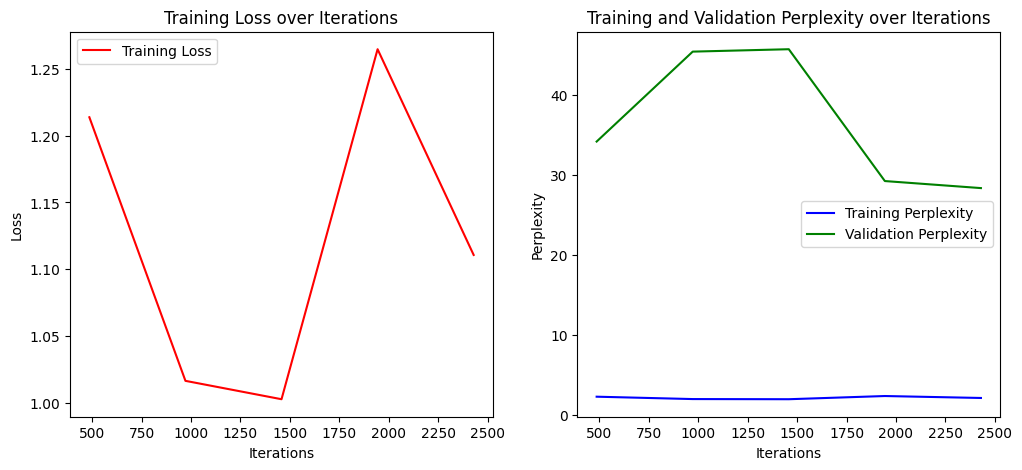

In [ ]:
lr = 0.001
batch_size = 100
epoch = 5
teacher_forcing=0.5
# Train
baseline_model = BaseEncoderDecoder(len(vocabulary), 256, device).to(device)
stats_baseline = {'iters': [],'train_loss': [], 'train_perp': [], 'val_perp': []}
criterion = nn.CrossEntropyLoss(ignore_index = vocabulary.get_stoi()["<unk>"])
optimizer_decoder = optim.Adam(baseline_model.decoder.parameters(), lr=lr)
optimizer_encoder = optim.Adam(baseline_model.encoder.parameters(), lr=lr)
train_model(baseline_model, train_data, validation_data, test_data, criterion, optimizer_encoder,
            optimizer_decoder, lr, batch_size,teacher_forcing,epoch,486,stats_baseline,plot=True)


Sample Recipes from Baseline Model

In [ ]:
predictions, truths, gen_inputs, common_words = generate_text(baseline_model, test_data, 1)
for i in range(len(predictions)):
    print(f"Sample {i + 1}:")
    print("Ingredients:", gen_inputs[i])
    print("Prediction:", predictions[i])
    print("Target:", truths[i])
    print("Common Words:", common_words[i])
    print("\n")

Sample 1:
Ingredients: <bos> cumin seeds coriander seeds cardamom pods cloves cinnamon stick greek yogurt small red onion finely chopped fresh lemon juice fresh lemon zest cayenne pepper fillet salmon cut horizontally inch thick <unk> oil drizzlingsalt freshly ground pepper inch wooden skewers soaked water minutes orange <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Prediction: <bos> in large large bowl bowl bowl bowl add add oil oil vinegar vinegar vinegar vinegar vinegar vinegar vinegar vinegar vinegar vinegar vinegar vinegar vinegar vinegar vinegar vinegar vinegar vinegar vinegar vinegar vinegar vinegar vinegar vinegar vinegar vinegar vinegar vinegar vinegar vine

Save the model

In [ ]:
save_info = {
    'model_state_dict': baseline_model.state_dict(),
    'optimizer_decoder_state_dict': optimizer_decoder.state_dict(),
    'optimizer_encoder_state_dict': optimizer_encoder.state_dict(),
    'loss_state_dict': criterion.state_dict()
}

with open('/content/drive/MyDrive/CSC413FinalBaselineModel.pkl', 'wb') as f:
    pickle.dump(save_info, f)

with open('/content/drive/MyDrive/CSC413FinalBaselineModel.pkl', 'rb') as f:
    loaded_info = pickle.load(f)

Let's train and evaluate the attention model

Learning Rate:  0.001 Batch Size:  100 Epochs:  5
486 Training Loss: 1.282170295715332
486 Training perplexity: 2.4320456280771205 Validation perplexity: 36.707579685424506
Sample 1:
Ingredients: <bos> olive oil red bell pepper seeded chopped guajillo chile seeded chopped cloves garlic chopped shallots chopped apple cider honey chicken stock chicken glaze veal chops <unk> pepperolive oil red chile glaze <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Prediction: <bos> preheat oven degrees f degrees c c grease grease baking baking dish dish dish dish dish dish dish dish dish dish dish dish dish dis

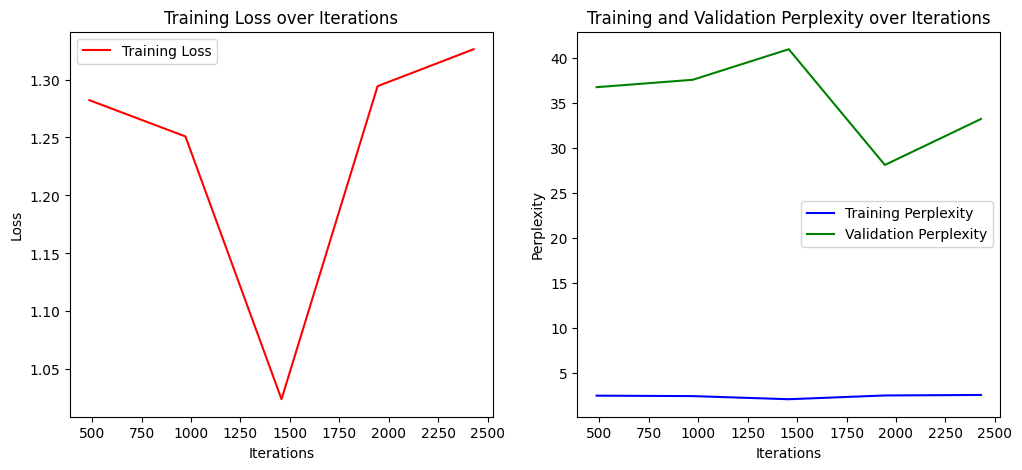

In [ ]:
lr = 0.001
batch_size = 100
epoch = 5
teacher_forcing=0.5
# Train
attention_model = AttentionEncoderDecoder(len(vocabulary), 256, device).to(device)
stats_attention = {'iters': [],'train_loss': [], 'train_perp': [], 'val_perp': []}
attention_criterion = nn.CrossEntropyLoss(ignore_index = vocabulary.get_stoi()["<unk>"])
attention_optimizer_encoder = optim.Adam(attention_model.encoder.parameters(), lr=lr)
attention_optimizer_decoder = optim.Adam(attention_model.decoder.parameters(), lr=lr)
train_model(attention_model, train_data, validation_data, test_data, attention_criterion,attention_optimizer_encoder,attention_optimizer_decoder,
            lr, batch_size,teacher_forcing,epoch,486,stats_attention,plot=True)


Sample Recipe from Attention Model

In [ ]:
predictions, truths, gen_inputs, common_words = generate_text(attention_model, test_data, 1)
for i in range(len(predictions)):
    print(f"Sample {i + 1}:")
    print("Ingredients:", gen_inputs[i])
    print("Prediction:", predictions[i])
    print("Target:", truths[i])
    print("Common Words:", common_words[i])
    print("\n")

Sample 1:
Ingredients: <bos> chopped pitted dates fresh orange juice ripe banana carton low fat vanilla yogurt crushed ice <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Prediction: <bos> combine ingredients ingredients cocktail cocktail shaker shaker shake vigorously vigorously strain cocktail cocktail glass glass <eos> <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad

Saving the Model

In [ ]:
import pickle
save_info = {
    'model_state_dict': attention_model.state_dict(),
    'optimizer_encoder_state_dict': attention_optimizer_encoder.state_dict(),
    'optimizer_decoder_state_dict': attention_optimizer_decoder.state_dict(),
    'loss_state_dict': attention_criterion.state_dict()
}

with open('/content/drive/MyDrive/CSC413FinalAttentionModel.pkl', 'wb') as f:
    pickle.dump(save_info, f)


<All keys matched successfully>

# Training and Evaluation Part 2

1.   Training with Teacher Forcing 100% of the time
2.   Learning Rate is 0.001



Let's train and evaluate the baseline model

Learning Rate:  0.001 Batch Size:  100 Epochs:  5
486 Training Loss: 0.024631548672914505
486 Training perplexity: 1.0172198701276323 Validation perplexity: 43.008742040425176
Sample 1:
Ingredients: <bos> ounces allpurpose flour salt cold unsalted butter cut inch pieces cold vegetable shortening cut inch pieces ice water needed pints blueberries sugar grated lemon zest blueberry vinegar quick tapioca cinnamon cold unsalted butter cut bits egg beaten <unk> <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Prediction: <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> 

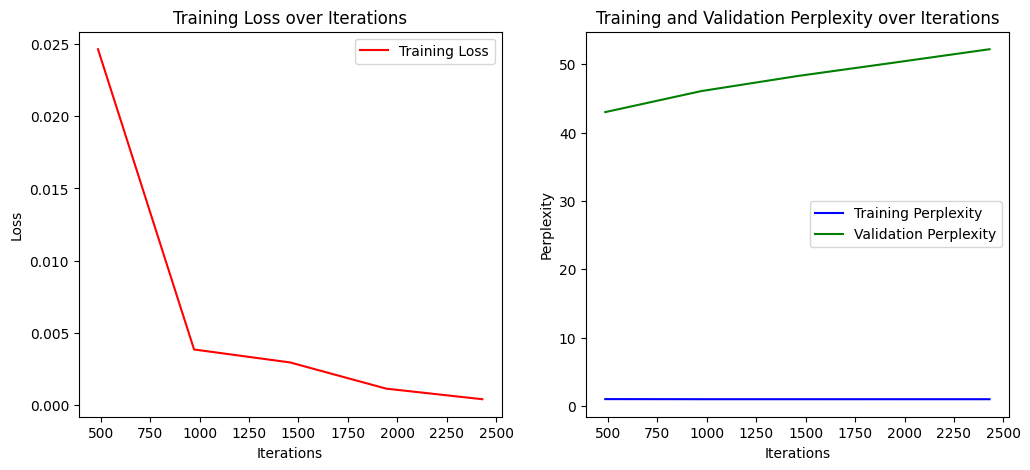

In [ ]:
lr = 0.001
batch_size = 100
epoch = 5
teacher_forcing=1
# Train
baseline_model = BaseEncoderDecoder(len(vocabulary), 256, device).to(device)
stats_baseline = {'iters': [],'train_loss': [], 'train_perp': [], 'val_perp': []}
criterion = nn.CrossEntropyLoss(ignore_index = vocabulary.get_stoi()["<unk>"])
optimizer_decoder = optim.Adam(baseline_model.decoder.parameters(), lr=lr)
optimizer_encoder = optim.Adam(baseline_model.encoder.parameters(), lr=lr)
train_model(baseline_model, train_data, validation_data, test_data, criterion, optimizer_encoder,
            optimizer_decoder, lr, batch_size,teacher_forcing,epoch,486,stats_baseline,plot=True)


It can be seen that the Baseline Model is overfitting when it is trained on teacher forcing all the time. The Validation perpleity keeps increasing as th Training Perplexity and Training Loss decrease. Thus, teacher forcing may not be the best way to train the model. We can effectively discard the model.

Let's train and evaluate the attention model

Learning Rate:  0.001 Batch Size:  100 Epochs:  5
486 Training Loss: 0.04202806204557419
486 Training perplexity: 1.0295601093444675 Validation perplexity: 43.88578082956008
Sample 1:
Ingredients: <bos> extravirgin olive oil minced garlic roma tomatoes seeded chopped inch pieces package frozen artichoke hearts thawed italian dressing mix dried oregano balsamic vinegar minced fresh parsley leaves <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Prediction: <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <

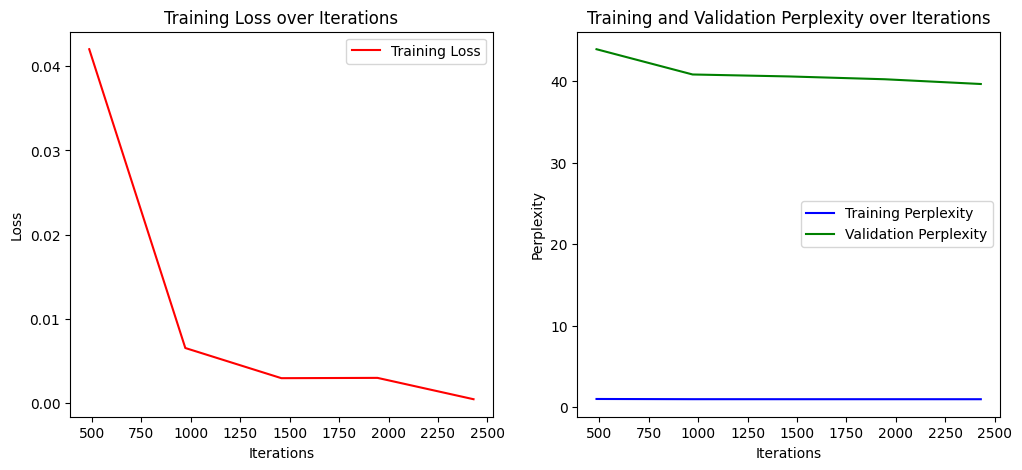

In [ ]:
lr = 0.001
batch_size = 100
epoch = 5
teacher_forcing=1
# Train
attention_model = AttentionEncoderDecoder(len(vocabulary), 256, device).to(device)
stats_attention = {'iters': [],'train_loss': [], 'train_perp': [], 'val_perp': []}
attention_criterion = nn.CrossEntropyLoss(ignore_index = vocabulary.get_stoi()["<unk>"])
attention_optimizer_encoder = optim.Adam(attention_model.encoder.parameters(), lr=lr)
attention_optimizer_decoder = optim.Adam(attention_model.decoder.parameters(), lr=lr)
train_model(attention_model, train_data, validation_data, test_data, attention_criterion, attention_optimizer_decoder,
            lr, batch_size,teacher_forcing,epoch,486,stats_attention,optimizer_encoder=attention_optimizer_encoder,plot=True)


It can be seen that the Attention Model is also overfitting when it is trained on teacher forcing all the time. The Validation perpleity keeps increasing as th Training Perplexity and Training Loss decrease. Thus, teacher forcing may not be the best way to train the model. We can effectively discard the model. We think that Teacher forcing doesn't allow the model to learn.

# Training and Evaluation Part 3

1.   Training with no Teacher
2.   Learning Rate is 0.001



Let's train and evaluate the baseline model

Learning Rate:  0.001 Batch Size:  100 Epochs:  5
486 Training Loss: 2.515453815460205
486 Training perplexity: 5.71777486455713 Validation perplexity: 7.415883629993912
Sample 1:
Ingredients: <bos> flour enough <unk> <unk> saltpinch black pepperpinch garlic powderpinch paprikapinch beef base powdered beef stock chicken <unk> cover frying <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Prediction: <bos> preheat oven degrees f degrees c heat heat heat heat heat minutes heat minutes heat minutes heat minutes heat minutes heat mi

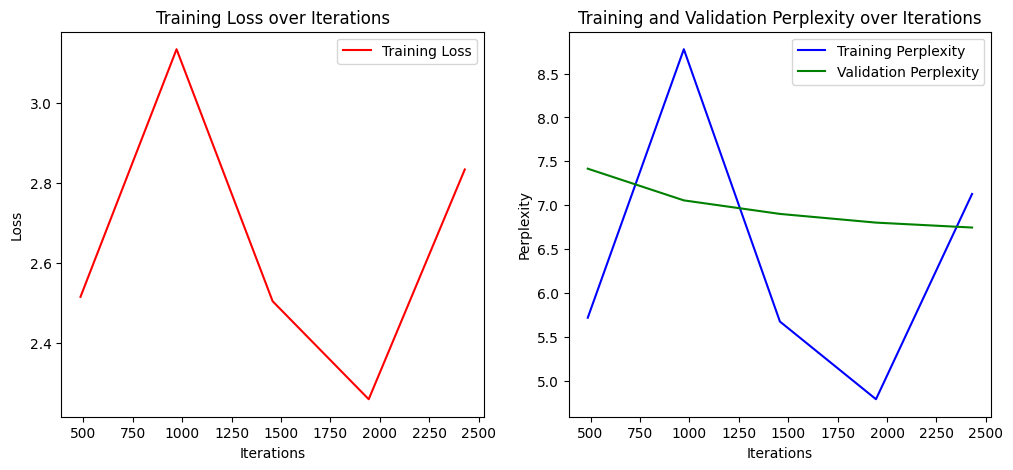

In [ ]:
lr = 0.001
batch_size = 100
epoch = 5
teacher_forcing=0
# Train
baseline_model = BaseEncoderDecoder(len(vocabulary), 256, device).to(device)
stats_baseline = {'iters': [],'train_loss': [], 'train_perp': [], 'val_perp': []}
criterion = nn.CrossEntropyLoss(ignore_index = vocabulary.get_stoi()["<unk>"])
optimizer_decoder = optim.Adam(baseline_model.decoder.parameters(), lr=lr)
optimizer_encoder = optim.Adam(baseline_model.encoder.parameters(), lr=lr)
train_model(baseline_model, train_data, validation_data, test_data, criterion, optimizer_encoder,
            optimizer_decoder, lr, batch_size,teacher_forcing,epoch,486,stats_baseline,plot=True)


Let's train and evaluate the attention model

Learning Rate:  0.001 Batch Size:  100 Epochs:  5
486 Training Loss: 2.7359182834625244
486 Training perplexity: 6.661828819797337 Validation perplexity: 7.146791304147746
Sample 1:
Ingredients: <bos> olive oil leftover sauteed sliced onions ounces leftover cooked steak cut bitesize pieces roasted red pepper strips stalks leftover cooked asparagus cut inch pieces milk large eggskosher salt freshly ground black pepper shredded cheese sharp cheddar fontina gruyere monterey jack <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Prediction: <bos> preheat oven degrees f degrees c heat heat add heat add heat add minutes heat minutes heat minutes heat minutes

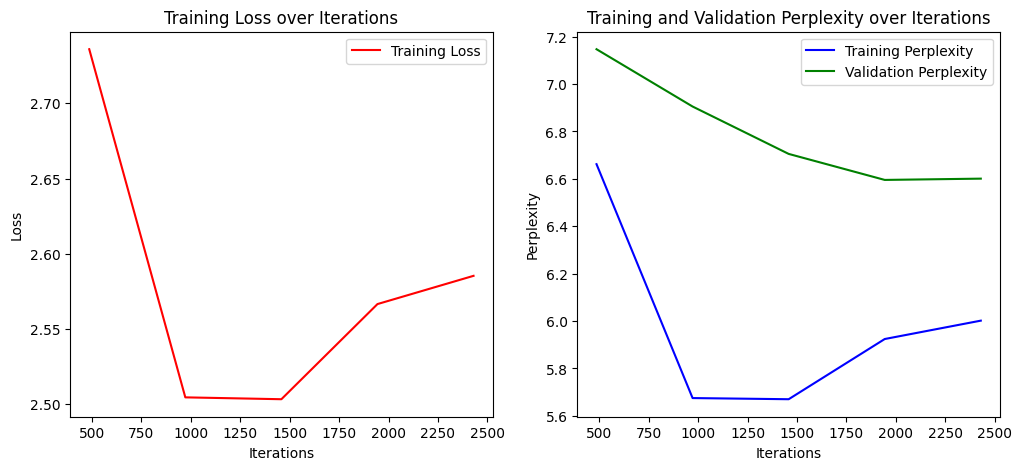

In [ ]:
lr = 0.001
batch_size = 100
epoch = 5
teacher_forcing=0
# Train
attention_model = AttentionEncoderDecoder(len(vocabulary), 256, device).to(device)
stats_attention = {'iters': [],'train_loss': [], 'train_perp': [], 'val_perp': []}
attention_criterion = nn.CrossEntropyLoss(ignore_index = vocabulary.get_stoi()["<unk>"])
attention_optimizer_encoder = optim.Adam(attention_model.encoder.parameters(), lr=lr)
attention_optimizer_decoder = optim.Adam(attention_model.decoder.parameters(), lr=lr)
train_model(attention_model, train_data, validation_data, test_data, attention_criterion,attention_optimizer_encoder, attention_optimizer_decoder,
            lr, batch_size,teacher_forcing,epoch,486,stats_attention,plot=True)


# Results

Let's put together all these graphs into two master graphs


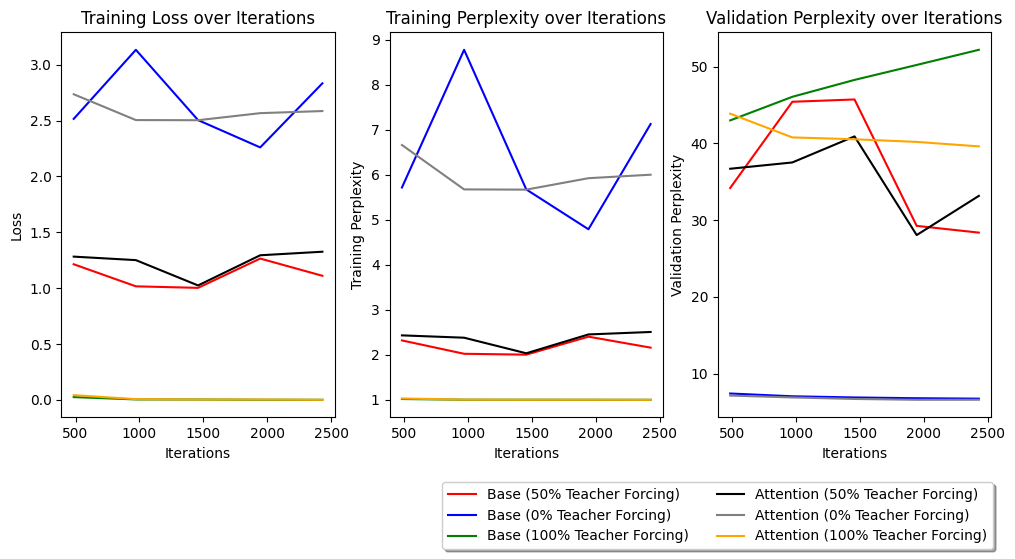

In [ ]:
results_figure, axes = plt.subplots(1, 3, figsize=(12, 5))
iterations = [486,972,1458,1944,2430]

base_training_loss_halftf = [1.2139,1.0163,1.0025,1.2649,1.1107]
base_training_perp_halftf = [2.3196,2.0227,2.0035,2.4031,2.1594]
base_val_perp_halftf = [34.1989,45.4364,45.7366,29.2639,28.3839]

attn_training_loss_halftf = [1.2822,1.2509,1.0242,1.2943,1.3261]
attn_training_perp_halftf = [2.4320,2.3799,2.0338,2.4525,2.5073]
attn_val_perp_halftf = [36.7076,37.5287,40.9258,28.0651,33.1717]

base_training_loss_tf = [0.0246,0.0038,0.0030,0.0011,0.0004]
base_training_perp_tf = [1.0172,1.0026,1.0020,1.0008,1.0003]
base_val_perp_tf = [43.0087,46.0846,48.2848,50.2346,52.2086]

attn_training_loss_tf = [0.0420,0.0065,0.0029,0.0030,0.0004]
attn_training_perp_tf = [1.0296,1.0045,1.0020,1.0021,1.0002]
attn_val_perp_tf = [43.8858,40.7910,40.5518,40.2060,39.6239]

base_training_loss_notf = [2.5154,3.1337,2.5045,2.2599,2.8335]
base_training_perp_notf = [5.7178,8.7769,5.6744,4.7895,7.1280]
base_val_perp_notf = [7.4159,7.0548,6.9006,6.8015,6.7455]

attn_training_loss_notf = [2.7359,2.5046,2.5034,2.5666,2.5854]
attn_training_perp_notf = [6.6618,5.6750,5.6700,5.9241,6.0016]
attn_val_perp_notf = [7.1468,6.9050,6.7051,6.5953,6.6008]

# Plotting training loss
axes[0].plot(iterations, base_training_loss_halftf, label="Base (50% Teacher Forcing)", color='red')
axes[0].plot(iterations, base_training_loss_notf, label="Base (0% Teacher Forcing)", color='blue')
axes[0].plot(iterations, base_training_loss_tf, label="Base (100% Teacher Forcing)", color='green')
axes[0].plot(iterations, attn_training_loss_halftf, label="Attention (50% Teacher Forcing)", color='black')
axes[0].plot(iterations, attn_training_loss_notf, label="Attention (0% Teacher Forcing)", color='grey')
axes[0].plot(iterations, attn_training_loss_tf, label="Attention (100% Teacher Forcing)", color='orange')
axes[0].set_title("Training Loss over Iterations")
axes[0].set_xlabel("Iterations")
axes[0].set_ylabel("Loss")

# Plotting training perplexity
axes[1].plot(iterations, base_training_perp_halftf, label="Base (50% Teacher Forcing)", color='red')
axes[1].plot(iterations, base_training_perp_notf, label="Base (0% Teacher Forcing)", color='blue')
axes[1].plot(iterations, base_training_perp_tf, label="Base (100% Teacher Forcing)", color='green')
axes[1].plot(iterations, attn_training_perp_halftf, label="Attention (50% Teacher Forcing)", color='black')
axes[1].plot(iterations, attn_training_perp_notf, label="Attention (0% Teacher Forcing)", color='grey')
axes[1].plot(iterations, attn_training_perp_tf, label="Attention (100% Teacher Forcing)", color='orange')
axes[1].set_title("Training Perplexity over Iterations")
axes[1].set_xlabel("Iterations")
axes[1].set_ylabel("Training Perplexity")


# Plotting validation perplexity
axes[2].plot(iterations, base_val_perp_halftf, label="Base (50% Teacher Forcing)", color='red')
axes[2].plot(iterations, base_val_perp_notf, label="Base (0% Teacher Forcing)", color='blue')
axes[2].plot(iterations, base_val_perp_tf, label="Base (100% Teacher Forcing)", color='green')
axes[2].plot(iterations, attn_val_perp_halftf, label="Attention (50% Teacher Forcing)", color='black')
axes[2].plot(iterations, attn_val_perp_notf, label="Attention (0% Teacher Forcing)", color='grey')
axes[2].plot(iterations, attn_val_perp_tf, label="Attention (100% Teacher Forcing)", color='orange')
axes[2].set_title("Validation Perplexity over Iterations")
axes[2].set_xlabel("Iterations")
axes[2].set_ylabel("Validation Perplexity")

plt.legend(loc='upper center', bbox_to_anchor=(0, -0.15), fancybox=True, shadow=True, ncol=2)

plt.show()